In [1]:
from __future__ import division
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import matplotlib.cm as cm

def constant_hazard(lam, r):
    return 1/lam * np.ones(r.shape)

class StudentT:
    def __init__(self, alpha, beta, kappa, mu):
        self.alpha0 = self.alpha = np.array([alpha])
        self.beta0 = self.beta = np.array([beta])
        self.kappa0 = self.kappa = np.array([kappa])
        self.mu0 = self.mu = np.array([mu])

    def pdf(self, data):
        return stats.t.pdf(x=data, 
                           df=2*self.alpha,
                           loc=self.mu,
                           scale=np.sqrt(self.beta * (self.kappa+1) / (self.alpha *
                               self.kappa)))

    def update_theta(self, data):
        muT0 = np.concatenate((self.mu0, (self.kappa * self.mu + data) / (self.kappa + 1)))
        kappaT0 = np.concatenate((self.kappa0, self.kappa + 1.))
        alphaT0 = np.concatenate((self.alpha0, self.alpha + 0.5))
        betaT0 = np.concatenate((self.beta0, self.beta + (self.kappa * (data -
            self.mu)**2) / (2. * (self.kappa + 1.))))
        self.mu = muT0
        self.kappa = kappaT0
        self.alpha = alphaT0
        self.beta = betaT0
        
def online_changepoint_detection(data, hazard_func, observation_likelihood):
    maxes = np.zeros(len(data) + 1)
    
    R = np.zeros((len(data) + 1, len(data) + 1))
    R[0, 0] = 1
    
    for t, x in enumerate(data):
        # Evaluate the predictive distribution for the new datum under each of
        # the parameters.  This is the standard thing from Bayesian inference.
        predprobs = observation_likelihood.pdf(x)
        
        # Evaluate the hazard function for this interval
        H = hazard_func(np.array(range(t+1)))
       
        # Evaluate the growth probabilities - shift the probabilities down and to
        # the right, scaled by the hazard function and the predictive
        # probabilities.
        R[1:t+2, t+1] = R[0:t+1, t] * predprobs * (1-H)
        
        # Evaluate the probability that there *was* a changepoint and we're
        # accumulating the mass back down at r = 0.
        R[0, t+1] = np.sum( R[0:t+1, t] * predprobs * H)
        
        # Renormalize the run length probabilities for improved numerical
        # stability.
        R[:, t+1] = R[:, t+1] / np.sum(R[:, t+1])
        
        # Update the parameter sets for each possible run length.
        observation_likelihood.update_theta(x)
    
        maxes[t] = R[:, t].argmax()
    return R, maxes

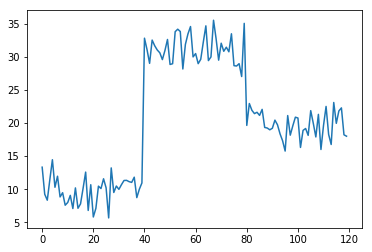

In [2]:
n=40
data = np.concatenate( [
    np.random.normal(10, 2, n),
    np.random.normal(30, 2, n), 
    np.random.normal(20, 2, n)])
plt.plot(data)

In [3]:
R, maxes = online_changepoint_detection(data, partial(constant_hazard, 100), StudentT(0.1, .01, 1, 0))

C:\Users\ciort\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


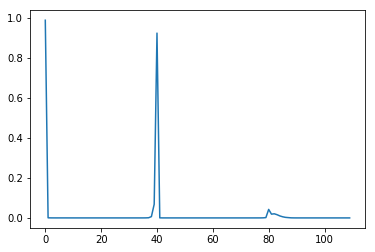

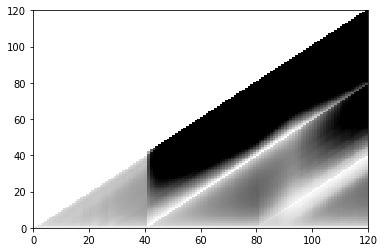

In [4]:
Nw=10;
plt.plot(R[Nw,Nw:-1])
# plt.plot(R[Nw,:])

plt.figure()
ax = plt.gca()
sparsity = 1  # only plot every fifth data for faster display
ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)

In [5]:
R[Nw,Nw:-1].argsort()[::-1]

array([  0,  40,  39,  80,  82,  81,  83,  84,  38,  85,  86,  79,  87,
        37,   1,  88,  78,  41,  36,   2,  89,   3,   5,   7,  42,  77,
         6,  35,   4,  43,   9,   8,  76,  90,  12,  11,  34,  10,  44,
        13,  14,  75,  18,  45,  33,  17,  91,  15,  19,  20,  16,  46,
        92,  21,  32,  22,  23,  24,  47,  31,  25,  74,  27,  26,  48,
        93,  28,  49,  29,  30,  50,  94,  73,  51,  95,  52,  53,  96,
        97,  54,  72,  98,  55, 100,  99, 101,  56, 102,  57, 105, 104,
        58, 103,  71, 106, 107, 108,  59, 109,  60,  61,  62,  63,  64,
        65,  66,  67,  69,  70,  68], dtype=int64)